In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("D:\\Projects\\Deep_Grasp\\deep_grasp_vgu\\deep_grasp_vgu\\deep_grasp_cnn\\src")

import ggcnn.ggcnn_torch as ggcnn_torch
from ggcnn.ggcnn_torch import predict, process_depth_image

import torch

ggcnn_torch.load_model_by_path("weights\\ggcnn_weights_cornell\\ggcnn_epoch_23_cornell")

from dougsm_helpers.gridshow import gridshow

Loading model from: weights\ggcnn_weights_cornell\ggcnn_epoch_23_cornell


D:\miniconda3\envs\yolox-build\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
D:\miniconda3\envs\yolox-build\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


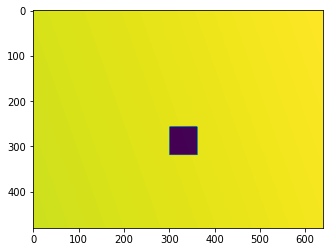

In [2]:
suff = "..\\..\\datasets\\self_data\\1663745306" + "_"

cam_fov = 60

depth = np.load(suff + "depth.npy")
camera_rot = np.load(suff + "camera_rot.npy")
cam_K = np.load(suff + "cam_K.npy")
cam_p = np.load(suff + "cam_p.npy")
plt.imshow(depth)

In [3]:
object_to_camera_matrix = np.load(suff + "object_to_camera_matrix.npy")
object_to_robot_matrix = np.load(suff + "object_to_robot_matrix.npy")

### Preprocess image

In [4]:
process_depth=True
crop_size=400
out_size=300
depth_nan_mask=None
crop_y_offset=0
filters=(2.0, 1.0, 1.0)

In [5]:
depth_crop, depth_nan_mask = process_depth_image(depth, crop_size, out_size=out_size, return_mask=True, crop_y_offset=crop_y_offset)

1: 0.0ms
2: 8.0ms
3: 0.0ms
4: 5.9ms
  Inpainting: 5.9ms
5: 10.2ms
6: 0.0ms


In [6]:
points, angle, width_img, _ = predict(depth_crop, process_depth=False, depth_nan_mask=depth_nan_mask, filters=(2.0, 2.0, 2.0))

In [16]:
import cv2

In [27]:
norm_image

array([[ 5,  4,  4, ...,  1,  1,  2],
       [ 5,  4,  4, ...,  1,  1,  2],
       [ 4,  4,  4, ...,  1,  1,  2],
       ...,
       [ 5,  5,  5, ...,  8,  9, 10],
       [ 6,  6,  6, ...,  9, 11, 12],
       [ 7,  7,  6, ..., 10, 11, 13]], dtype=uint8)

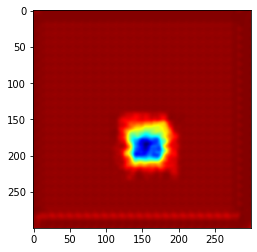

In [29]:
plt.imshow(cv2.applyColorMap(norm_image,  cv2.COLORMAP_JET))

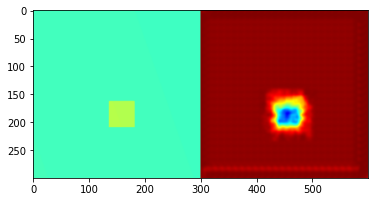

In [7]:
show = gridshow('Display',
            [depth_crop, points],
            [(0.2, 0.55), None, (-np.pi/2, np.pi/2)],
            [cv2.COLORMAP_JET, cv2.COLORMAP_JET, cv2.COLORMAP_BONE],
            3,
            False)
plt.imshow(show)

In [15]:
points

array([[0.01565552, 0.01533275, 0.01494639, ..., 0.00252565, 0.00475473,
        0.00636558],
       [0.01569574, 0.01547468, 0.01527818, ..., 0.00265084, 0.00478342,
        0.00632899],
       [0.01501075, 0.01496201, 0.0150734 , ..., 0.00276336, 0.00458939,
        0.00591939],
       ...,
       [0.01701037, 0.01734237, 0.01767014, ..., 0.0262163 , 0.03162325,
        0.03503987],
       [0.02161645, 0.0213156 , 0.02052812, ..., 0.03049269, 0.03648614,
        0.0402815 ],
       [0.02482503, 0.02407789, 0.02251246, ..., 0.03325522, 0.03953627,
        0.04350938]], dtype=float32)

In [8]:
# Mask Points Here
angle -= np.arcsin(camera_rot[0, 1])  # Correct for the rotation of the camera
angle = (angle + np.pi/2) % np.pi - np.pi/2  # Wrap [-np.pi/2, np.pi/2]

In [9]:
cam_K, cam_p, camera_rot

(array([[554.38271282,   0.        , 320.5       ],
        [  0.        , 554.38271282, 240.5       ],
        [  0.        ,   0.        ,   1.        ]]),
 array([-0.12841071,  0.40881558,  0.38502977]),
 array([[ 9.99992594e-01,  5.25325389e-04,  3.81262376e-03],
        [ 5.33498540e-04, -9.99997561e-01, -2.14300720e-03],
        [ 3.81148869e-03,  2.14502535e-03, -9.99990436e-01]]))

In [10]:
best_g = np.argmax(points)
best_g_unr = np.unravel_index(best_g, points.shape)

In [11]:
depth.shape

(480, 640)

In [12]:
# Convert to 3D positions.
imh, imw = depth.shape
x = ((np.vstack((np.linspace((imw - crop_size) // 2, (imw - crop_size) // 2 + crop_size, depth_crop.shape[1], np.float), )*depth_crop.shape[0]) - cam_K[0, 2])/cam_K[0, 0] * depth_crop).flatten()
y = ((np.vstack((np.linspace((imh - crop_size) // 2 - crop_y_offset, (imh - crop_size) // 2 + crop_size - crop_y_offset, depth_crop.shape[0], np.float), )*depth_crop.shape[1]).T - cam_K[1,2])/ cam_K[1, 1] * depth_crop).flatten()
pos = np.dot(camera_rot, np.stack((x, y, depth_crop.flatten()))).T + np.array([[cam_p[0], cam_p[1], cam_p[2]]])

width_m = width_img / 300.0 * 2.0 * depth_crop * np.tan(cam_fov * crop_size/depth.shape[0] / 2.0 / 180.0 * np.pi)

best_g = np.argmax(points)
best_g_unr = np.unravel_index(best_g, points.shape)

D:\miniconda3\envs\yolox-build\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
D:\miniconda3\envs\yolox-build\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the c

In [13]:
## Extract grasp information
grasp_x = pos[best_g, 0]
grasp_y = pos[best_g, 1]
grasp_z = pos[best_g, 2]
grasp_orientation_x = np.pi
grasp_orientation_y = 0
grasp_orientation_z = (angle[best_g_unr]%np.pi) - np.pi/2
grasp_width = width_m[best_g_unr]
grasp_quality = points[best_g_unr]

In [14]:
grasp_pose = [grasp_x, grasp_y, grasp_z]
ground_truth_position = list(object_to_robot_matrix[0:3, 3])
print(ground_truth_position)
print(grasp_pose)

[-0.10253859608477642, 0.36496619068585984, 0.016016640385228542]
[-0.12260393649509488, 0.3785804465414675, 0.027245858474744478]


In [90]:
scale_ratio  = crop_size / out_size;
crop_offset  = np.array(depth.shape) - crop_size

cx = cam_K[0, 2]; cy = cam_K[1, 2]
fx = cam_K[0, 0]; fy = cam_K[1, 1]

# Compensate scale 
scale_position = np.array(best_g_unr)*scale_ratio

# Compensate crop
compensated_position = scale_position + crop_offset // 2

pos_x_image =  compensated_position[1]
pos_y_image = compensated_position[0]

pos_x_real = ((pos_x_image - cx) / fx)*depth[int(pos_y_image), int(pos_x_image)]
pos_y_real = ((pos_y_image - cy) / fy)*depth[int(pos_y_image), int(pos_x_image)]

pos_x_real, pos_y_real

(0.003980706623948007, 0.0289408130227573)

[-0.10253859608477642, 0.36496619068585984, 0.016016640385228542]

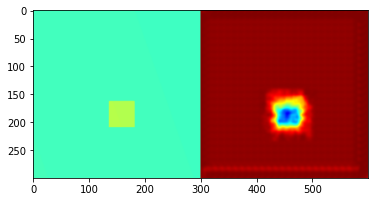